# DQN example with Pong

## Colab 용 package 설치 코드

In [1]:
!apt-get install cmake libz-dev zlib1g-dev python-opengl
!pip install gym
!pip install gym[atari]
!pip install JSAnimation

E: 잠금 파일 /var/lib/dpkg/lock-frontend 파일을 열 수 없습니다 - open (13: 허가 거부)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### package import

In [1]:
# The typical imports
from IPython.display import clear_output
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

import tensorflow as tf

np.random.seed(777)
tf.set_random_seed(777)
random.seed(777)

print("tensorflow version: ", tf.__version__)
print("gym version: ", gym.__version__)

tensorflow version:  1.8.0
gym version:  0.11.0


### 게임 화면을 보여주기 위한 함수

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

### 그래프를 그리기 위한 함수

In [3]:
def plot(frame_idx, episode, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

### gym 환경 전처리

In [4]:
from gym import spaces
from collections import deque
import cv2
cv2.ocl.setUseOpenCL(False)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=True):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=TeX-MML-AM_CHTML' async></script>
## Pong

In [5]:
# Pong 환경
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)

state_size = env.observation_space.shape
action_size = env.action_space.n
print("Observation size : ", state_size)
print("Action size : ", action_size)

Observation size :  (84, 84, 4)
Action size :  6



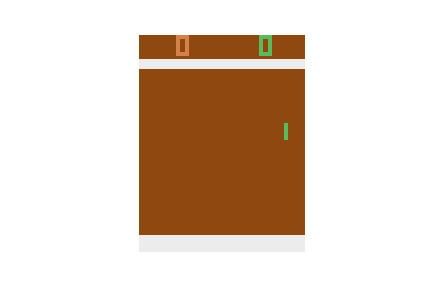
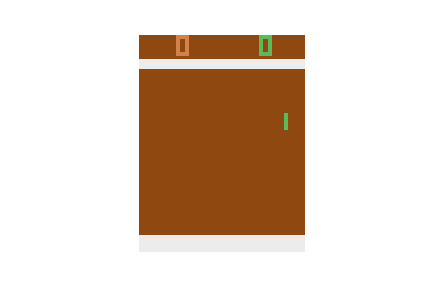
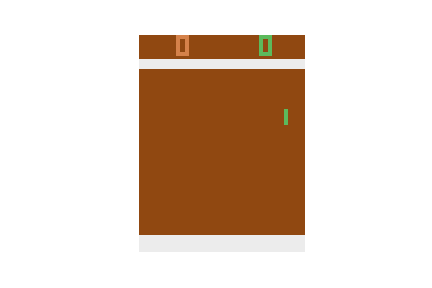
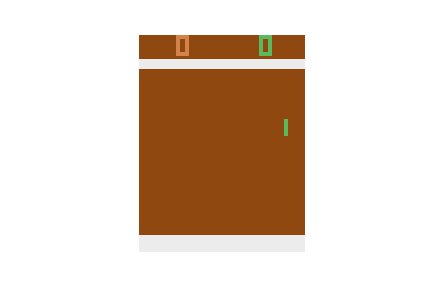
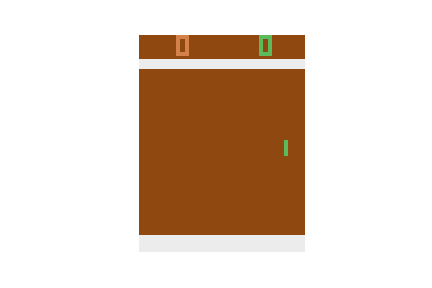
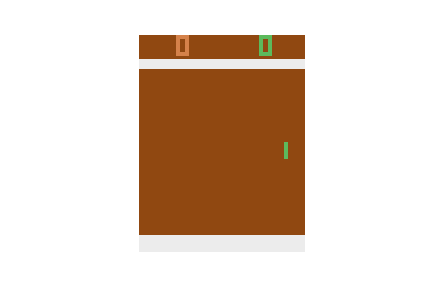
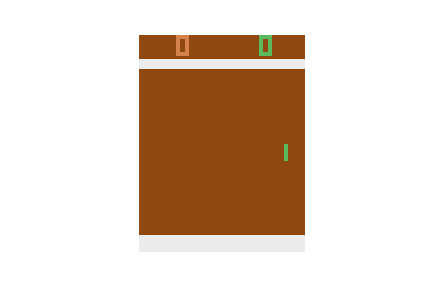
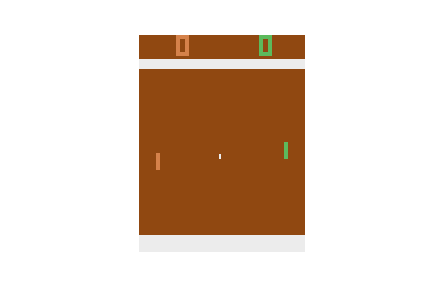
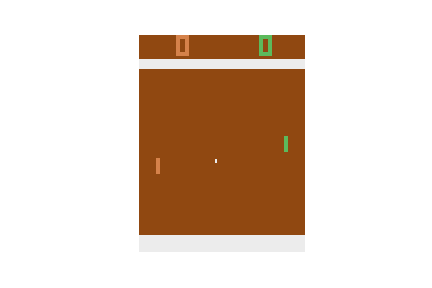
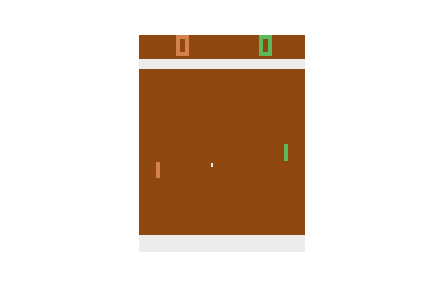
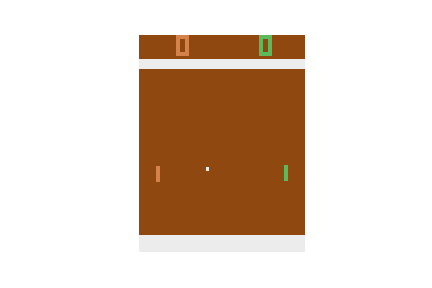
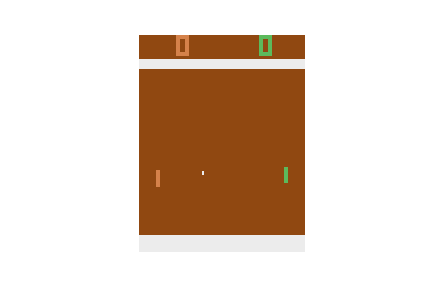
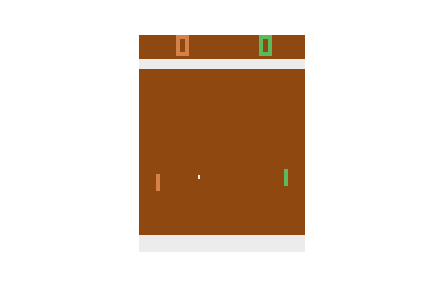
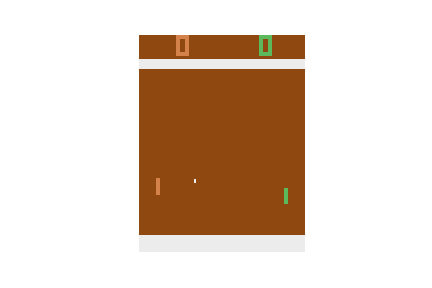
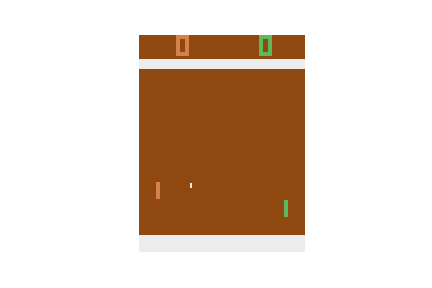
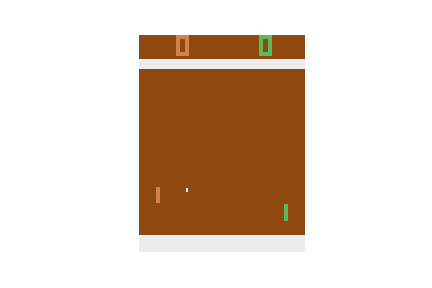
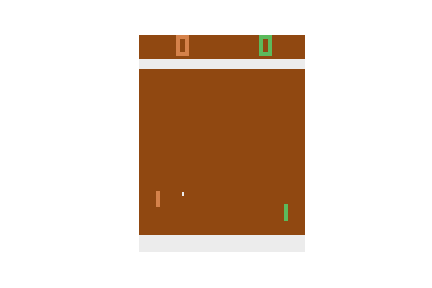
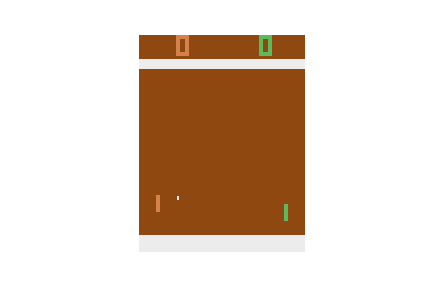
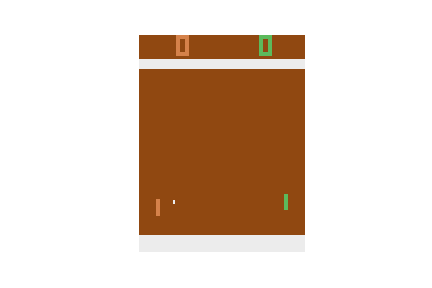
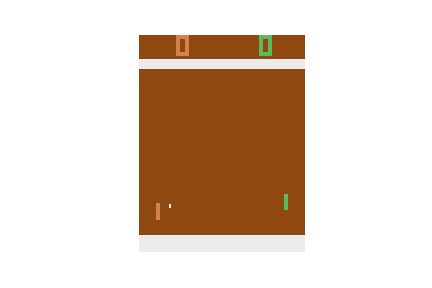
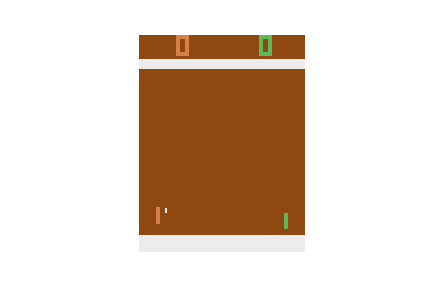
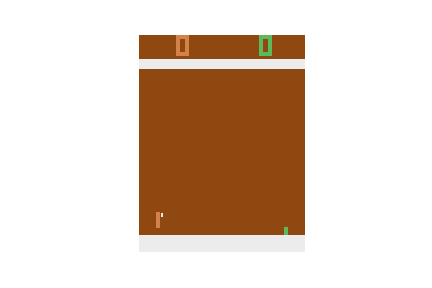
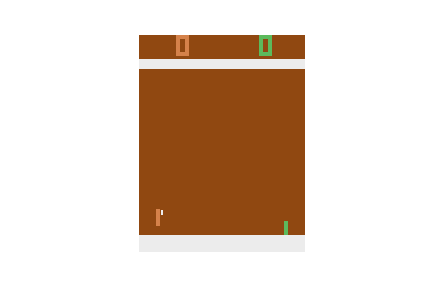
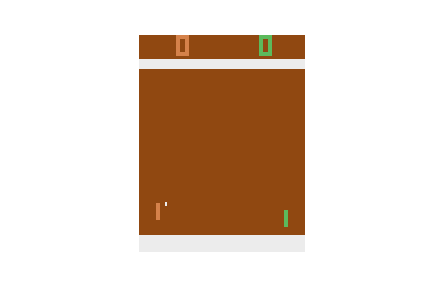
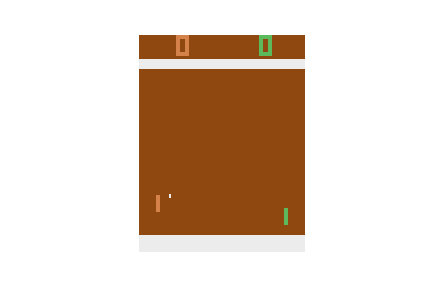
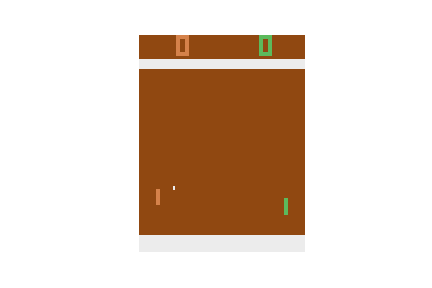
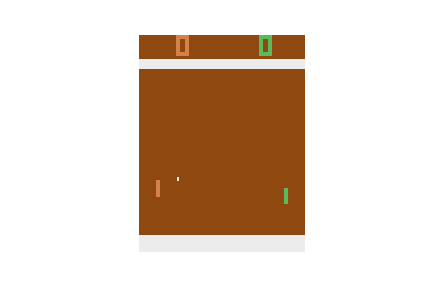
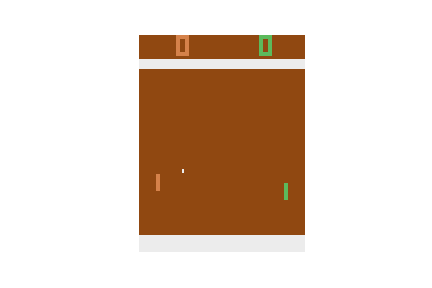
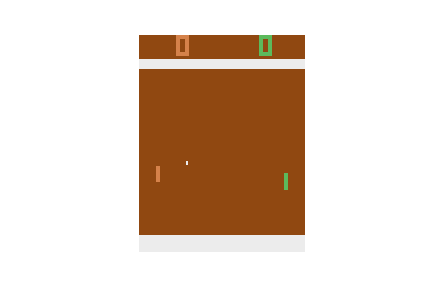
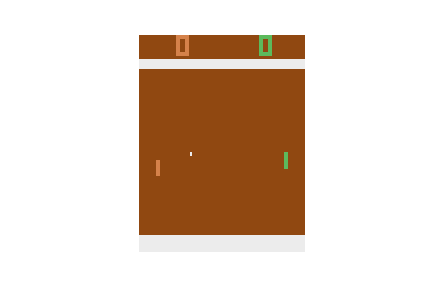
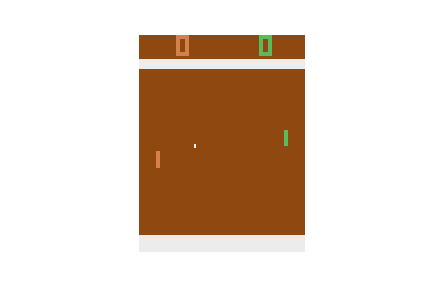
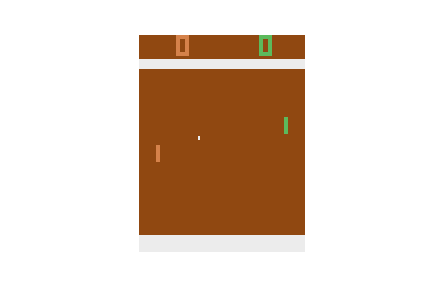
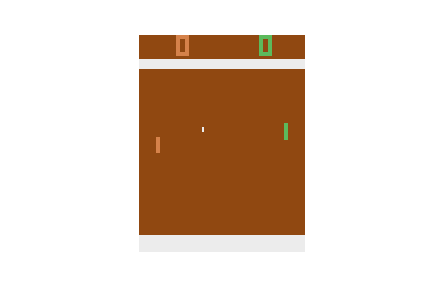
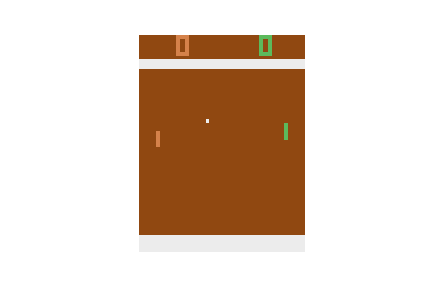
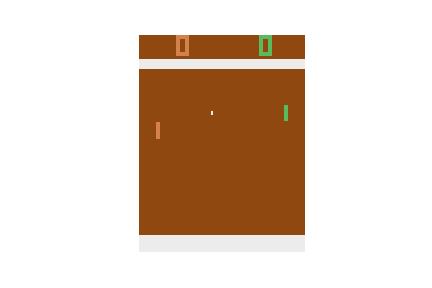
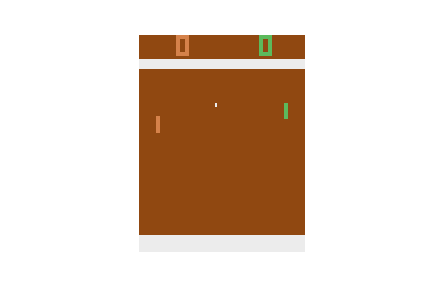
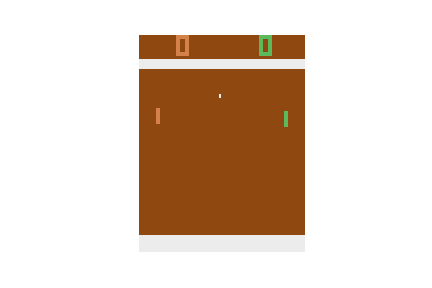
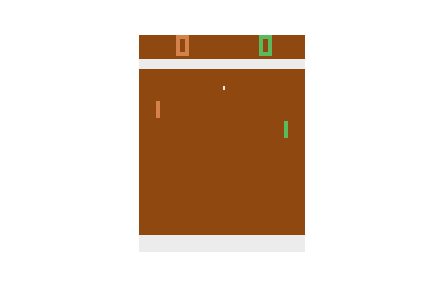
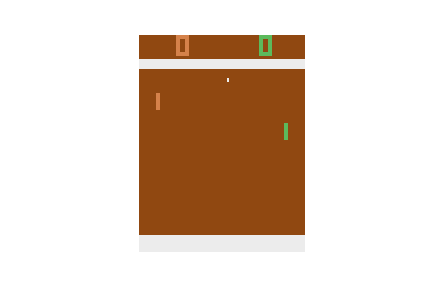
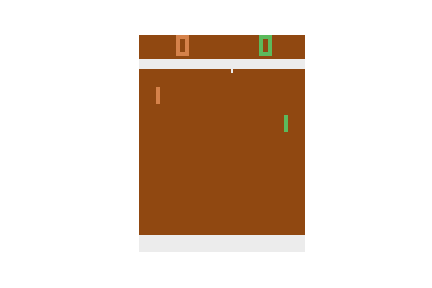
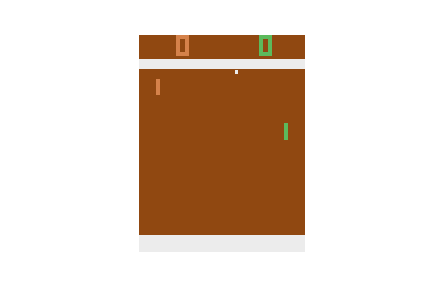
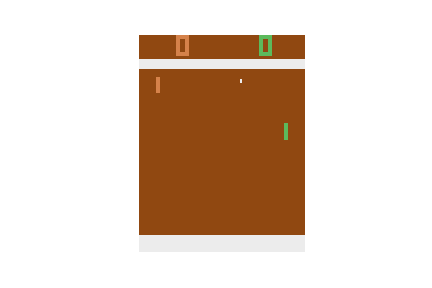
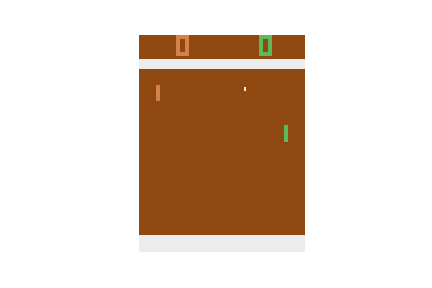
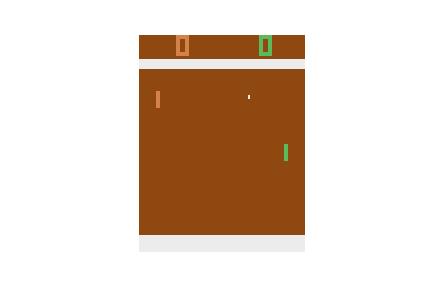
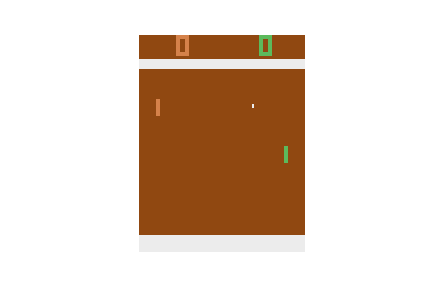
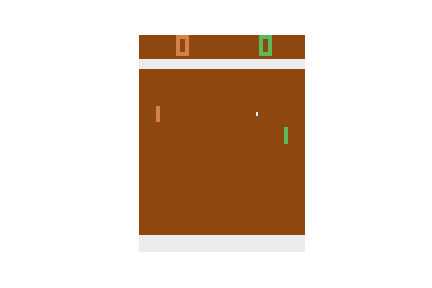
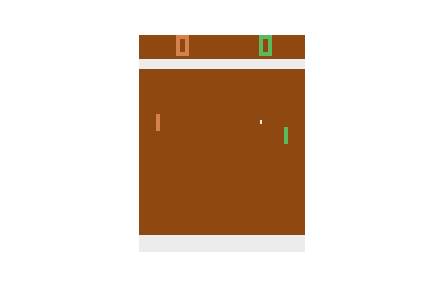
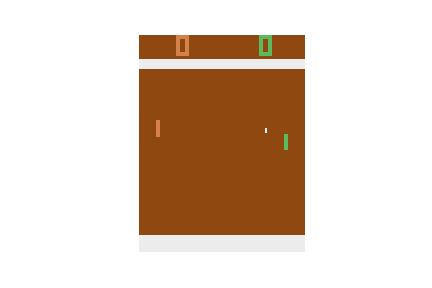
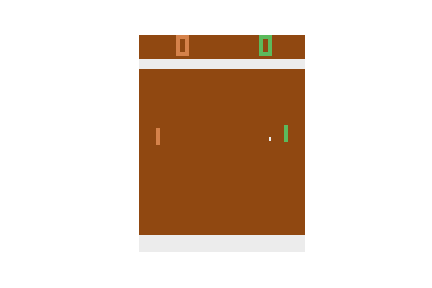
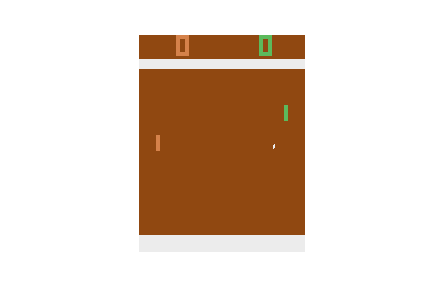
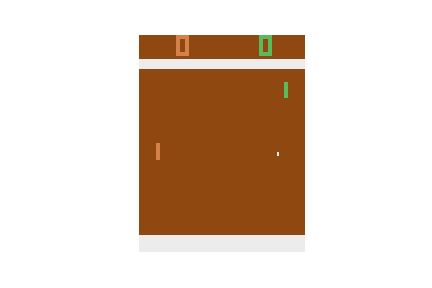
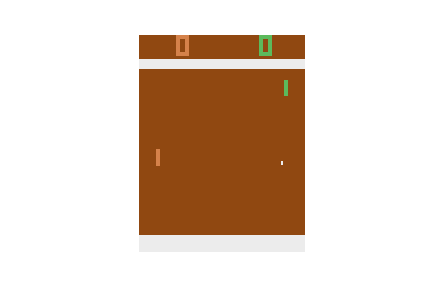
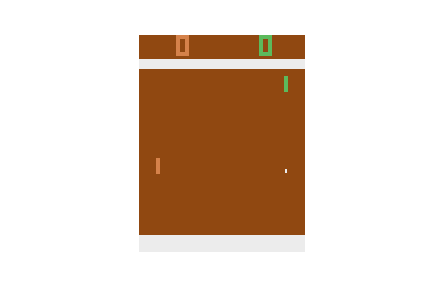
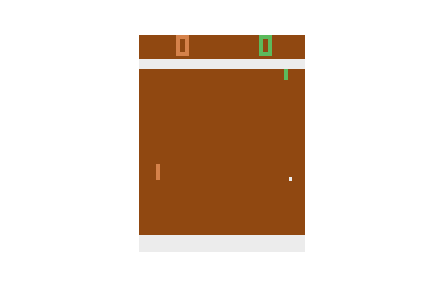
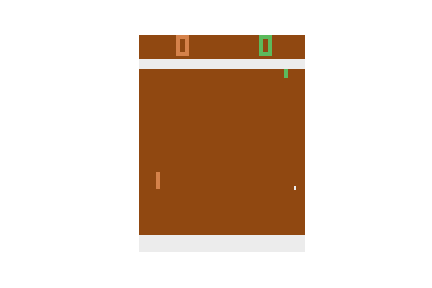
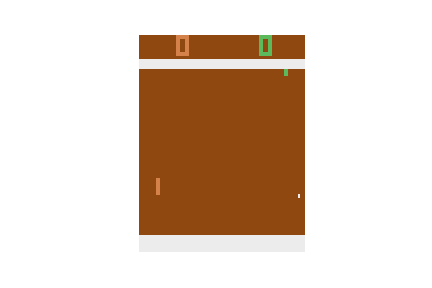
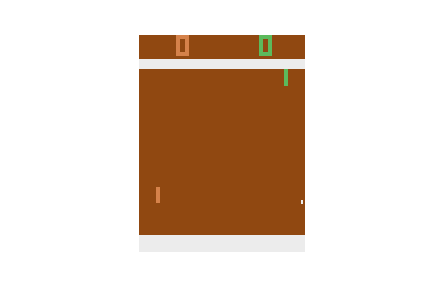
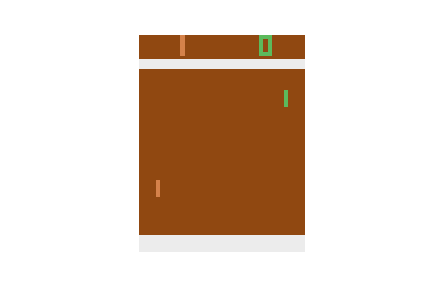
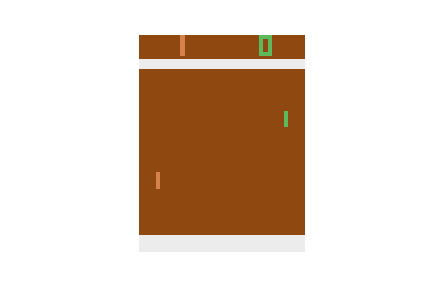
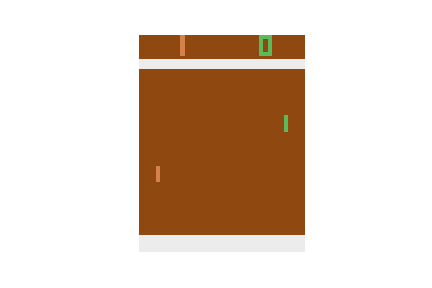
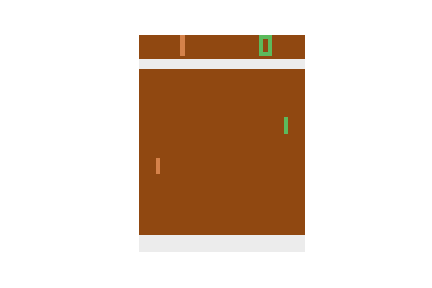
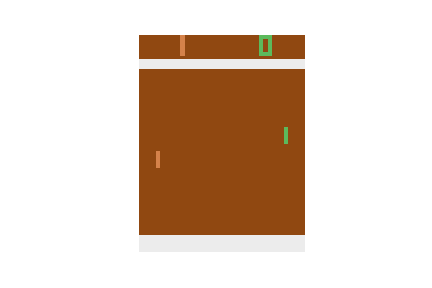
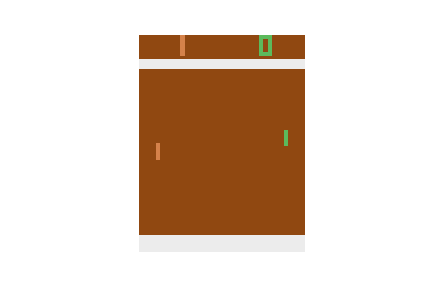
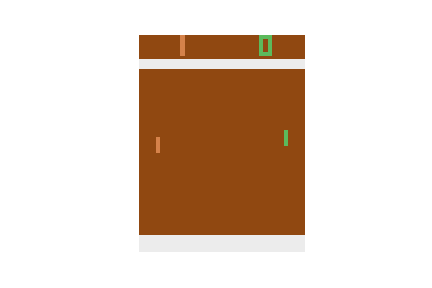
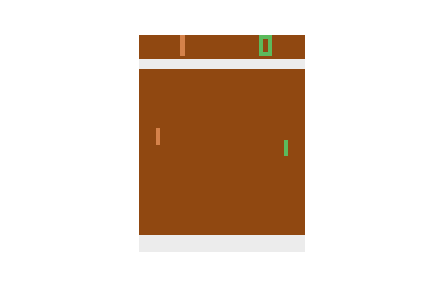
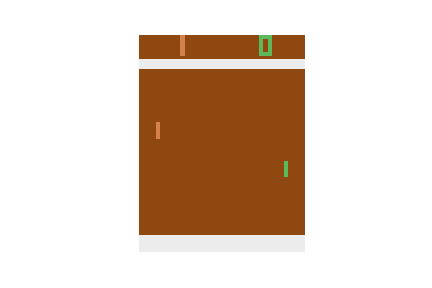
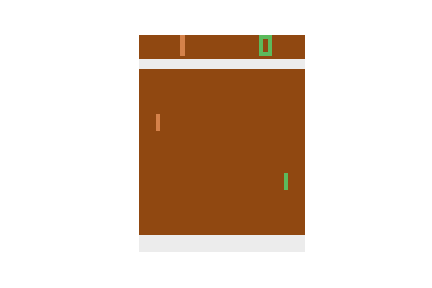
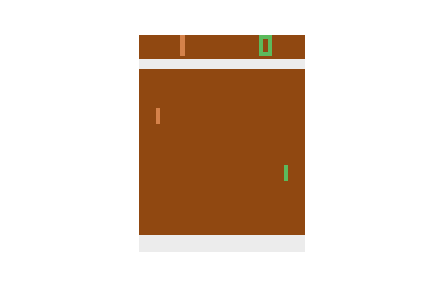
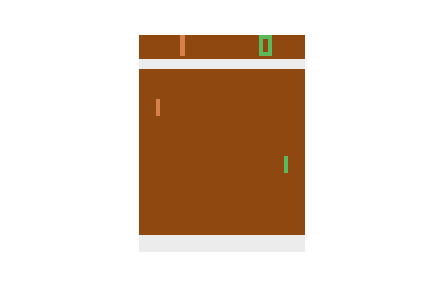
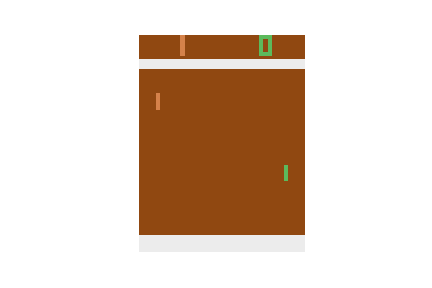
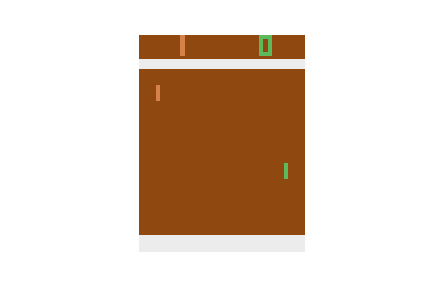
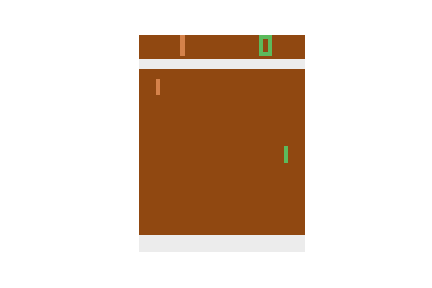
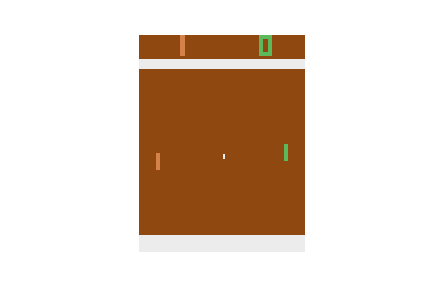
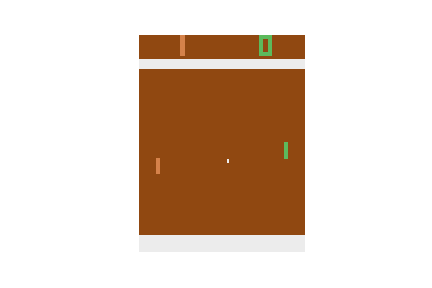
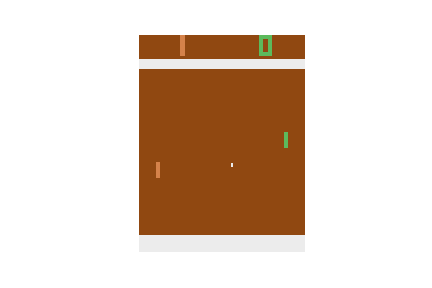
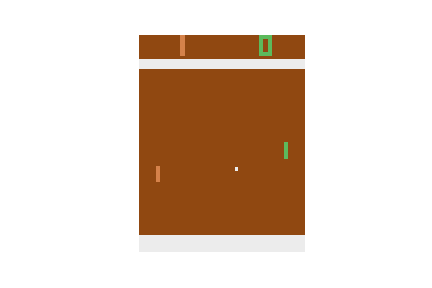
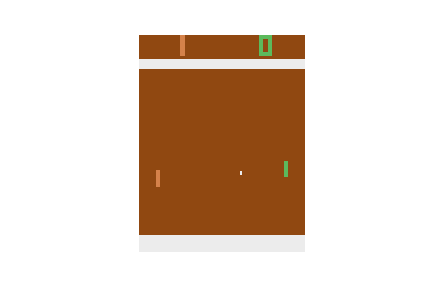
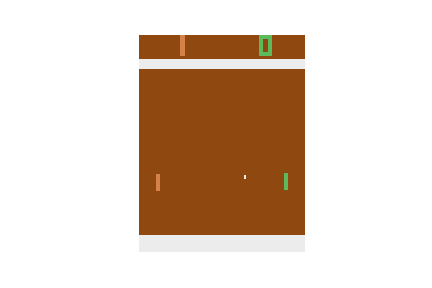
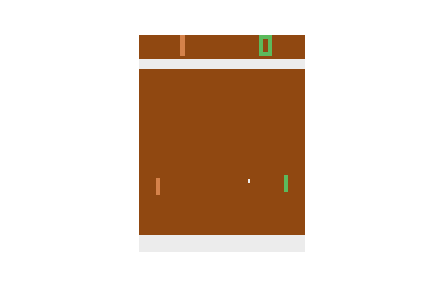
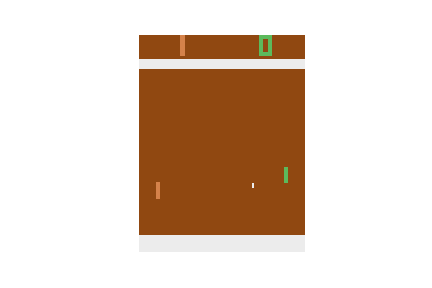
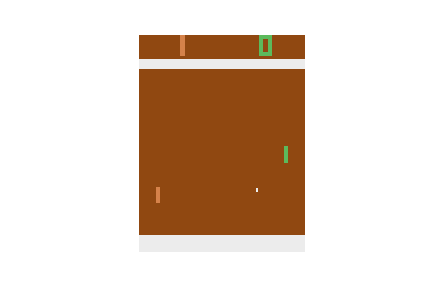
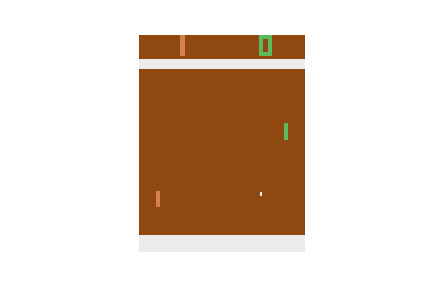
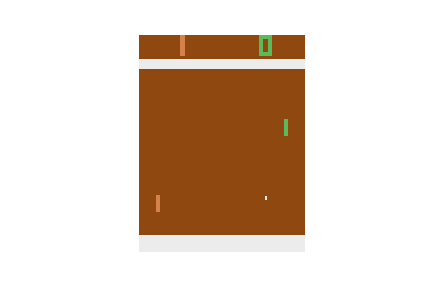
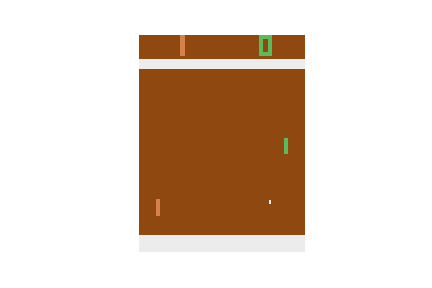
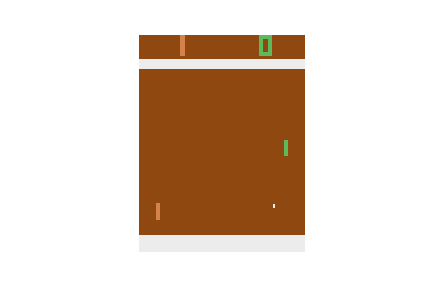
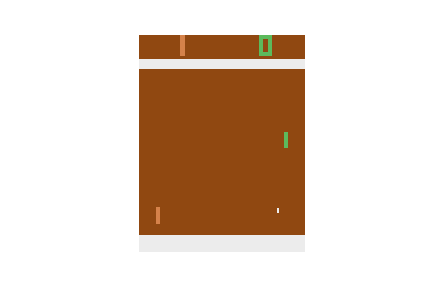
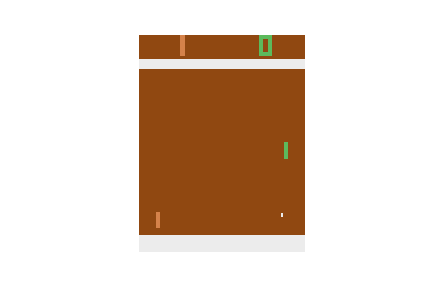
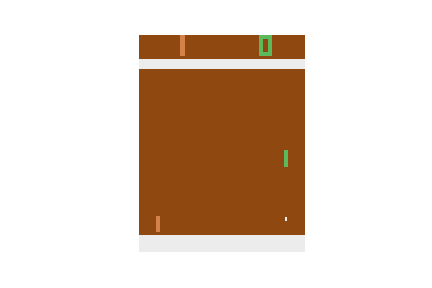
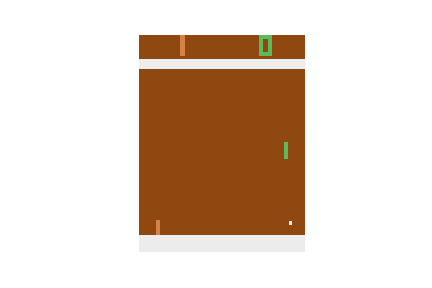
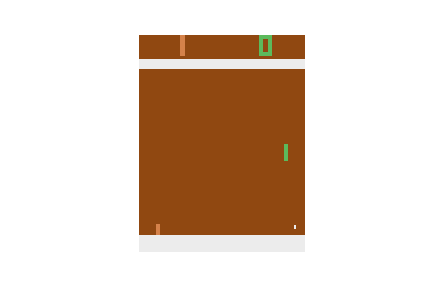
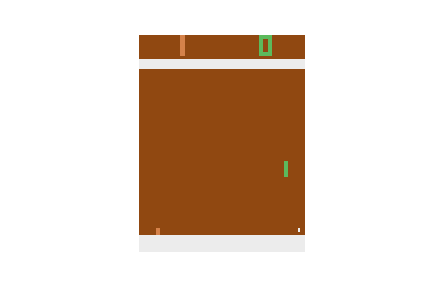
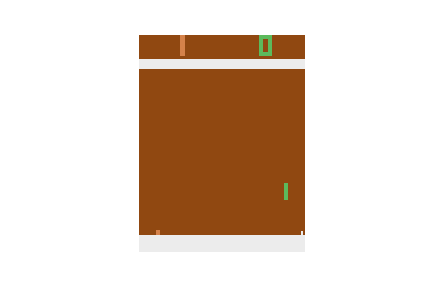
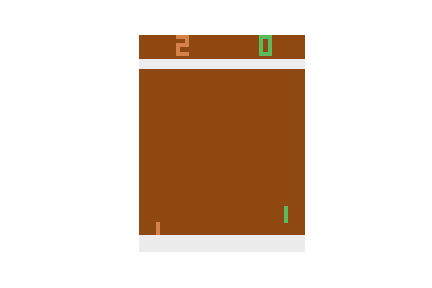
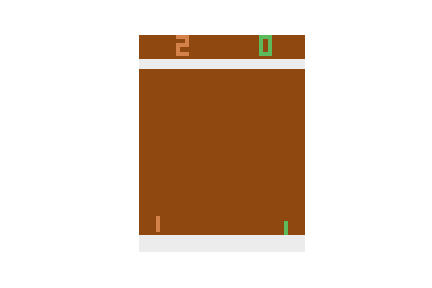
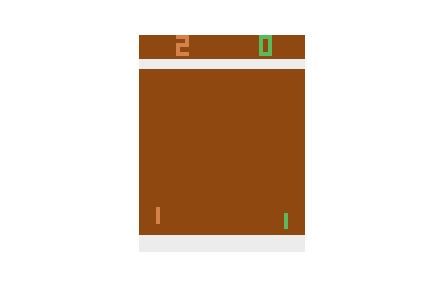
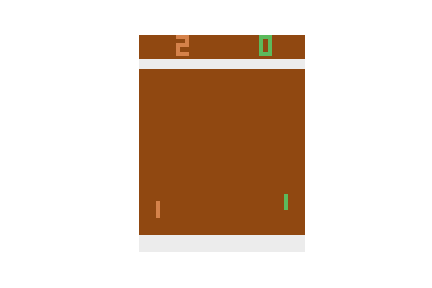
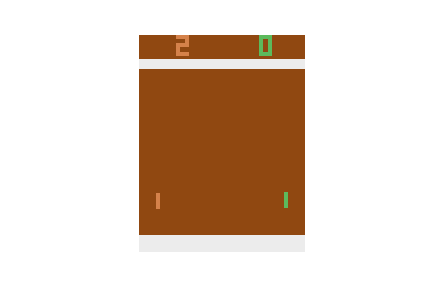
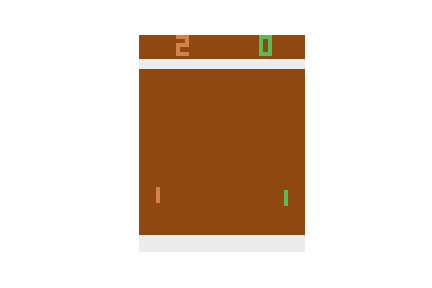
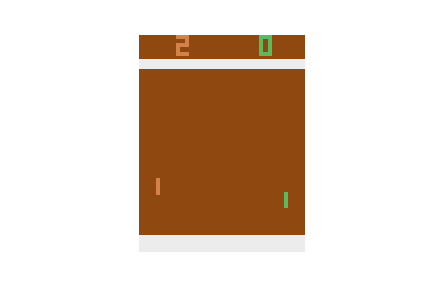
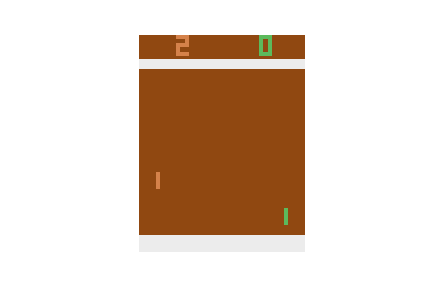

In [6]:
# Run a demo of the environment
observation = env.reset()
frames = []
for t in range(100):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()
display_frames_as_gif(frames)

### DQN Agent

Q Learning에서 Q함수의 업데이트식은 다음과 같다.
$$Q(s,a) \gets Q(s,a) +  \alpha [r + \gamma Q(s \prime, argmax_{a\prime} Q(s \prime,  a\prime) - Q(s,a)]$$  
DQN에서는 업데이트식에서 TD error 부분을 Loss로 보고 학습한다.
$$ Loss = E [(y - Q(s,a))^{2}]$$

### Replay Buffer

In [7]:
# Unifrom Replay Buffer
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.idx = 0
    
    # buffer 길이 체크
    def __len__(self):
        return len(self.buffer)
    
    # buffer에 sample 추가
    def add(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        
        if len(self.buffer) == self.capacity:
            self.buffer[self.idx] = transition
            self.idx = (self.idx + 1) % self.capacity
            
        else:
            self.buffer.append(transition)
    
    # buffer에서 batch_size만큼 뽑기
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        state, action, reward, next_state, done = [], [], [], [], []
        for i in idxs:
            s, a, r, n_s, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(n_s, copy=False))
            done.append(np.array(d, copy=False))

        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        done = np.array(done)
        
        return state, action, reward, next_state, done

### DQN Agent Class
<img src="./img/hyperparameters.png" width="100%" align="left"> 

In [8]:
layer = tf.contrib.layers

class DQNAgent:
    def __init__(self, sess, state_size, action_size):
        self.sess = sess

        self.state_size = state_size
        self.action_size = action_size

        # hyper parameter
        self.batch_size = 32
        self.discount_factor = 0.99
        self.learning_rate = 0.00025

        # epsilon
        self.s_epsilon = 1.0
        self.e_epsilon = 0.01
        self.n_epsilon_decay = 10000
        self.epsilon = self.s_epsilon

        # place holder
        self.input_policy = tf.placeholder(tf.float32, shape=(
            None, self.state_size[0], self.state_size[1], self.state_size[2]
        ))
        self.input_target = tf.placeholder(tf.float32, shape=(
            None, self.state_size[0], self.state_size[1], self.state_size[2]
        ))
        
        self.actions = tf.placeholder(tf.int32, shape=None)
        self.targets = tf.placeholder(tf.float32, shape=None)

        # network
        self.policy_q = self._build_network(self.input_policy, net_name="policy_net")
        self.target_q = self._build_network(self.input_target, net_name="target_net")
        self.sess.run(tf.global_variables_initializer())
        self.update_target_network()

        # replay buffer
        self.buffer = ReplayBuffer(10000)

        # optimizer
        self.loss_op, self.train_op = self._build_op()
        
    def _build_network(self, inputs, net_name):
        with tf.variable_scope(net_name):   
            conv1 = layer.conv2d(
                inputs, num_outputs=32, kernel_size=[8, 8], stride=[4, 4]
            )
            conv2 = layer.conv2d(
                conv1, num_outputs=64, kernel_size=[4, 4], stride=[2, 2]
            )
            conv3 = layer.conv2d(
                conv2, num_outputs=64, kernel_size=[3, 3]
            )
            conv3_flatten = layer.flatten(conv3)
            
            fc1 = layer.fully_connected(
                conv3_flatten, 128, activation_fn=tf.nn.relu
            )
            fc2 = layer.fully_connected(
                fc1, 128, activation_fn=tf.nn.relu
            )
            q_value = layer.fully_connected(
                fc2, self.action_size, activation_fn=None
            )
        return q_value

    def _build_op(self):
        """신경망 학습을 위한 Loss function과 Optimaizer를 정의합니다."""
        action_one_hot = tf.one_hot(self.actions, self.action_size, 1.0, 0.0)
        predict_q = tf.reduce_sum(tf.multiply(self.policy_q, action_one_hot), axis=1)

        loss_op = tf.reduce_mean(tf.square(self.targets - predict_q))
        train_op = tf.train.RMSPropOptimizer(
            learning_rate=self.learning_rate,
            decay=0.95,
            momentum=0.95,
            epsilon=0.01
        ).minimize(loss_op)
        return loss_op, train_op

    def select_action(self, state):
        """epsilon-greedy로 action을 선택합니다."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = np.random.randint(self.action_size)
        else:
            state = np.expand_dims(state, axis=0)
            selected_action = self.sess.run(
                self.policy_q,
                feed_dict={self.input_policy: state}
            )
            selected_action = np.argmax(selected_action, axis=1)
            selected_action = selected_action[0]

        # 매 step마다 epsilon을 줄여나갑니다.
        if self.epsilon >= self.e_epsilon:
            self.epsilon -= (self.s_epsilon - self.e_epsilon) / self.n_epsilon_decay
        return selected_action

    def update_model(self):
        """학습 네트워크를 학습합니다."""
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

        target_q = self.target_q.eval({self.input_target: next_states}, self.sess)
        target_q = np.max(target_q, axis=1)
        targets = rewards + self.discount_factor * target_q * (1. - dones)

        loss, _ = self.sess.run(
            [self.loss_op, self.train_op],
            feed_dict={self.input_policy: states,
                       self.actions: actions,
                       self.targets: targets})

        return loss

    def update_target_network(self):
        """학습 네트웍의 변수의 값들을 타겟 네트웍으로 복사해서 타겟 네트웍의 값들을 최신으로 업데이트합니다."""
        copy_op = []

        main_q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="policy_net")
        target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target_net")

        for main_q_var, target_var in zip(main_q_vars, target_vars):
            copy_op.append(target_var.assign(main_q_var.value()))
        self.sess.run(copy_op)

### DQN agent train

In [9]:
# Session 열기
tf.reset_default_graph()
sess = tf.Session()

# DQN Agent 객체 생성
agent = DQNAgent(sess, state_size, action_size)

# 변수 초기화
sess.run(tf.global_variables_initializer())

### DQN 학습

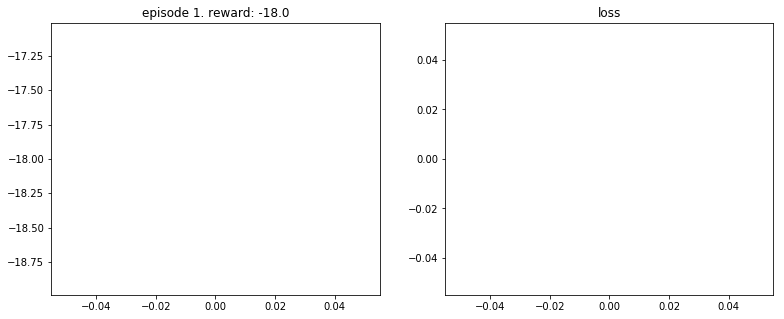

KeyboardInterrupt: 

In [10]:
EPISODE = 250

replay_initial = 1000
target_update = 100

total_step = 1
all_episode_reward = []
losses = []

for e in range(EPISODE):
    print("EPISODE: {}".format(e+1))
    observation = env.reset()
    done = False
   
    step = 1
    episode_reward = 0
    frames = []
    
    while not done:
        
        # action 선택
        action = int(agent.select_action(observation))
        
        # 선택한 action으로 env.step()
        next_observation, reward, done, _ = env.step(action)
        step += 1
        total_step += 1
        episode_reward += reward
        
        # trajectory(S, A, R, S', done)를 Replay buffer에 저장 
        agent.buffer.add(observation, action, reward, next_observation, done)
        
        observation = next_observation
        
        # 만약에 episode가 끝났으면 reward 저장
        if done:
            all_episode_reward.append(episode_reward)
        
        # replay buffer가 일정 이상 채워지면 학습 시작
        if len(agent.buffer) > replay_initial:
            loss = agent.update_model()
            losses.append(loss)
            
        # 일정 step마다 target Q 업데이트
        if total_step > replay_initial and total_step % target_update == 0:
            agent.update_target_network()
            
        # 그래프 그리기
        if total_step % 1000 == 0:
            plot(step, e, all_episode_reward, losses)
            
    print(total_step)
    print(step)
    print(all_episode_reward)  
    
    print(total_step)
    env.close()

### 학습된 DQN 테스트

In [ ]:
EPISODE = 1

all_episode_reward = []
losses = []

for e in range(EPISODE):
    print("EPISODE: {}".format(e+1))
    observation = env.reset()
    done = False
   
    step = 1
    episode_reward = 0
    frames = []
    
    agent.epsilon = 0
    
    while not done:
        action = int(agent.select_action(observation))
        
        next_observation, reward, done, _ = env.step(action)
        step += 1
        total_step += 1
        episode_reward += reward
        
        observation = next_observation
        
        if done:
            all_episode_reward.append(episode_reward)
        
        # 게임화면 보여주기
        if e % 1 == 0:
            frames.append(env.render(mode = 'rgb_array'))
            
    env.close()
    print("step", step)
    print("reward", episode_reward)
    if len(frames) > 0:
        display_frames_as_gif(frames)